<a href="https://colab.research.google.com/github/whkaikai/AI/blob/main/VGAE_TRAIN_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Train and Test is having a division of [35,5] (Total 40 samples for flexion)

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from numpy import genfromtxt
import networkx as nx
from scipy import sparse
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
import scipy.sparse as sp
import numpy as np
import os
import time
from scipy import sparse
from numpy import genfromtxt
from scipy.stats import norm
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans

# Dataset creation and Division

dataset = np.zeros((40,150,154))
i = -1
for name in glob.glob('/content/drive/My Drive/COMBINED-WITH-BAD/FLEX/AdjF_flex*'):
	i=i+1
	dataset[i,:,:] = genfromtxt(name, delimiter=',')


train_set, test_set = torch.utils.data.random_split(dataset,[35, 5])

# Shuffle and divide the data into train and test
trainloader = torch.utils.data.DataLoader(dataset = train_set, shuffle=True)
testloader =  torch.utils.data.DataLoader(dataset = test_set, shuffle=False)

In [2]:
## Model Definition
class VGAE(nn.Module):
	def __init__(self):
		super(VGAE,self).__init__()
		self.base_gcn = GraphConvSparse(150, 16)
		self.gcn_mean = GraphConvSparse(16, 2, activation=lambda x:x)
		self.gcn_logstddev = GraphConvSparse(16, 2, activation=lambda x:x)

	def encode(self, adj, X):
		hidden = self.base_gcn(adj,X)
		self.mean = self.gcn_mean(adj,hidden)
		self.logstd = self.gcn_logstddev(adj,hidden)
    # Gaussian Noise that we create
		gaussian_noise = torch.randn(X.size(0), 2)
    # This is the z distribution that we get z = mu + sigma*noise
		sampled_z = gaussian_noise*torch.exp(self.logstd) + self.mean
		return sampled_z

	def forward(self, adj, X):
		Z = self.encode(adj,X)
		A_pred = dot_product_decode(Z)
		return A_pred,Z

# Creating Graph Convolution Module		
class GraphConvSparse(nn.Module):
	def __init__(self, input_dim, output_dim, activation = F.relu, **kwargs):
		super(GraphConvSparse, self).__init__(**kwargs)
    # This will initialise the weights of the network
		self.weight = glorot_init(input_dim, output_dim)
		self.activation = activation

# This part will do the multiplication of AXW0
	def forward(self, adj, inputs):
		x = inputs
		x = torch.mm(x,self.weight.double())
		x = torch.mm(adj, x)
		outputs = self.activation(x)
		return outputs

# This is responsible for decoding
def dot_product_decode(Z):
	A_pred = torch.sigmoid(torch.matmul(Z,Z.t()))
	return A_pred

# This is for initliasation. The dimensions would be given in the argument
def glorot_init(input_dim, output_dim):
	init_range = np.sqrt(6.0/(input_dim + output_dim))
	initial = torch.rand(input_dim, output_dim)*2*init_range - init_range
	return nn.Parameter(initial)

# Responsible for Normalisation of Adjacency matrix
def preprocess_graph(adj):
    adj_ = sp.coo_matrix(adj)
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized 


def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec>0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    #print((preds_all == labels_all).sum().float())
    return accuracy		

model = VGAE()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()		

In [3]:
# Train the data
threshold = 0.5
train_loss = []
acc = []
def train(no_epoch):
  model.train()
  for epoch in range(no_epoch):
    for batch,data in enumerate(trainloader):      
      a = data[0,:,0:150]
      b = data[0,:,0:150]
      a[a<0]=0
      a[np.abs(a)>=threshold]=1
      a[np.abs(a)<threshold]=0
      A = sparse.csr_matrix(a)
      A_norm = preprocess_graph(A)
      A_norm = torch.from_numpy(A_norm.todense())
      A_label = torch.from_numpy(A.todense())
      features = sparse.csr_matrix(b)
      features = torch.from_numpy(features.todense())
      A_pred,Z = model(A_norm,features)
      optimizer.zero_grad()
      loss = criterion(A_pred.view(-1), A_label.view(-1))
      kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*model.logstd - model.mean**2 - torch.exp(model.logstd)).sum(1).mean()
      loss -= kl_divergence
      train_loss.append(loss)
      loss.backward()
      optimizer.step()
      train_acc = get_acc(A_pred,A_label)
      acc.append(train_acc) 
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss.item()),"train_acc=", "{:.5f}".format(train_acc))
  print("End of Training")
  plt.plot(train_loss)
  plt.ylabel('loss plot')
  plt.show()
  plt.plot(acc)
  plt.ylabel('accuracy plot')
  plt.show()
  print("Mean train loss",sum(train_loss) / len(train_loss) )
  print("Mean train accuracy",sum(acc) / len(acc))


In [4]:
# Clustering for test samples
def Clustering(Z):
  for batch,data in enumerate(testloader):
    a = data[0,:,0:150]
    X = Z[batch,:,:]
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
    A_Zlabels = kmeans.labels_
    print(A_Zlabels)
    color_map = []
    G = nx.from_numpy_matrix(a.numpy())
    plt.figure(1)
    nx.draw(G)
    count_red = 0
    count_blue = 0
    count_green = 0
    for node in G:
      if A_Zlabels[node]==1:
        color_map.append('red')
        count_red = count_red + 1 
      elif A_Zlabels[node]==2:
          color_map.append('blue')
          count_blue = count_blue + 1
      else:
         color_map.append('green')  
         count_green = count_green + 1  

    print("Red Nodes",count_red) 
    print("Blue Nodes",count_blue)    
    print("Green Nodes",count_green)
    plt.figure(2)       
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()

In [5]:
# Test the model
def test():
  threshold = 0.5
  test_loss = []
  Testacc = []
  Z_test = np.zeros((5,150,2))
  for batch,data in enumerate(testloader):
    a = data[0,:,0:150]
    b = data[0,:,0:150]
    a[a<0]=0
    a[np.abs(a)>=threshold]=1
    a[np.abs(a)<threshold]=0
    A = sparse.csr_matrix(a)
    A_norm = preprocess_graph(A)
    A_norm = torch.from_numpy(A_norm.todense())
    A_label = torch.from_numpy(A.todense())
    features = sparse.csr_matrix(b)
    features = torch.from_numpy(features.todense())
    A_pred,Z = model(A_norm,features) 
    Z_test[batch,:,:]=Z.detach().numpy()   
    loss = log_lik = criterion(A_pred.view(-1), A_label.view(-1))
    kl_divergence = 0.5/ A_pred.size(0) * (1 + 2*model.logstd - model.mean**2 - torch.exp(model.logstd)).sum(1).mean()
    loss -= kl_divergence
    test_loss.append(loss)
    test_acc = get_acc(A_pred,A_label)
    Testacc.append(test_acc) 
    print( "test_loss=", "{:.5f}".format(loss.item()),"test_acc=", "{:.5f}".format(test_acc))
  plt.plot(test_loss)
  plt.ylabel('loss plot for test')
  plt.show()
  plt.plot(Testacc)
  plt.ylabel('accuracy plot for test')
  plt.show()
  print("Mean test loss",sum(test_loss) / len(test_loss) )
  print("Mean test accuracy",sum(Testacc) / len(Testacc))
  return Z_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0001 train_loss= 0.30890 train_acc= 0.50373


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0002 train_loss= 0.30194 train_acc= 0.50098


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0003 train_loss= 0.30742 train_acc= 0.49636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0004 train_loss= 0.30844 train_acc= 0.49724
Epoch: 0005 train_loss= 0.29996 train_acc= 0.49707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0006 train_loss= 0.32435 train_acc= 0.49191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0007 train_loss= 0.31768 train_acc= 0.49840


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0008 train_loss= 0.31017 train_acc= 0.49902


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0009 train_loss= 0.31100 train_acc= 0.49858


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0010 train_loss= 0.30357 train_acc= 0.49449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0011 train_loss= 0.30912 train_acc= 0.49831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0012 train_loss= 0.31350 train_acc= 0.49582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0013 train_loss= 0.30717 train_acc= 0.49342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0014 train_loss= 0.29997 train_acc= 0.49662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0015 train_loss= 0.32076 train_acc= 0.47876
Epoch: 0016 train_loss= 0.30190 train_acc= 0.49627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0017 train_loss= 0.31463 train_acc= 0.49511
Epoch: 0018 train_loss= 0.30909 train_acc= 0.48862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0019 train_loss= 0.30666 train_acc= 0.49627
Epoch: 0020 train_loss= 0.30008 train_acc= 0.49360


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0021 train_loss= 0.31266 train_acc= 0.49760
Epoch: 0022 train_loss= 0.31913 train_acc= 0.49938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0023 train_loss= 0.30028 train_acc= 0.49324
Epoch: 0024 train_loss= 0.30681 train_acc= 0.49191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0025 train_loss= 0.31073 train_acc= 0.49893
Epoch: 0026 train_loss= 0.30708 train_acc= 0.49724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0027 train_loss= 0.30749 train_acc= 0.49307
Epoch: 0028 train_loss= 0.32196 train_acc= 0.48720


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0029 train_loss= 0.30940 train_acc= 0.49804
Epoch: 0030 train_loss= 0.31385 train_acc= 0.49876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0031 train_loss= 0.30964 train_acc= 0.49742
Epoch: 0032 train_loss= 0.30478 train_acc= 0.49467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0033 train_loss= 0.31601 train_acc= 0.49582
Epoch: 0034 train_loss= 0.31333 train_acc= 0.49511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0035 train_loss= 0.31370 train_acc= 0.50098
Epoch: 0036 train_loss= 0.30576 train_acc= 0.48773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0037 train_loss= 0.30780 train_acc= 0.49556
Epoch: 0038 train_loss= 0.31396 train_acc= 0.49573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0039 train_loss= 0.31073 train_acc= 0.49227
Epoch: 0040 train_loss= 0.30567 train_acc= 0.50062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0041 train_loss= 0.30241 train_acc= 0.49947
Epoch: 0042 train_loss= 0.31232 train_acc= 0.49840


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0043 train_loss= 0.30653 train_acc= 0.49867
Epoch: 0044 train_loss= 0.30213 train_acc= 0.49947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0045 train_loss= 0.30563 train_acc= 0.50027
Epoch: 0046 train_loss= 0.30178 train_acc= 0.49849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0047 train_loss= 0.29539 train_acc= 0.49840
Epoch: 0048 train_loss= 0.30292 train_acc= 0.49564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0049 train_loss= 0.29615 train_acc= 0.49867
Epoch: 0050 train_loss= 0.29784 train_acc= 0.49849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0051 train_loss= 0.30500 train_acc= 0.49493
Epoch: 0052 train_loss= 0.31496 train_acc= 0.49804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0053 train_loss= 0.29925 train_acc= 0.50249
Epoch: 0054 train_loss= 0.30263 train_acc= 0.49964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0055 train_loss= 0.30895 train_acc= 0.50364
Epoch: 0056 train_loss= 0.30746 train_acc= 0.50169


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0057 train_loss= 0.31243 train_acc= 0.49938
Epoch: 0058 train_loss= 0.31566 train_acc= 0.49653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0059 train_loss= 0.31689 train_acc= 0.49324
Epoch: 0060 train_loss= 0.30522 train_acc= 0.50142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0061 train_loss= 0.32369 train_acc= 0.48684
Epoch: 0062 train_loss= 0.30450 train_acc= 0.49653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0063 train_loss= 0.30327 train_acc= 0.49813
Epoch: 0064 train_loss= 0.30432 train_acc= 0.49422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0065 train_loss= 0.31139 train_acc= 0.48951
Epoch: 0066 train_loss= 0.30951 train_acc= 0.49538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0067 train_loss= 0.31593 train_acc= 0.49982
Epoch: 0068 train_loss= 0.31273 train_acc= 0.50116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0069 train_loss= 0.30609 train_acc= 0.49049
Epoch: 0070 train_loss= 0.32427 train_acc= 0.49387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0071 train_loss= 0.30752 train_acc= 0.49751
Epoch: 0072 train_loss= 0.31373 train_acc= 0.49840


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0073 train_loss= 0.31262 train_acc= 0.49680
Epoch: 0074 train_loss= 0.30791 train_acc= 0.49520


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0075 train_loss= 0.29526 train_acc= 0.49964
Epoch: 0076 train_loss= 0.30348 train_acc= 0.49911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0077 train_loss= 0.31371 train_acc= 0.48942
Epoch: 0078 train_loss= 0.31419 train_acc= 0.49698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0079 train_loss= 0.30444 train_acc= 0.50462
Epoch: 0080 train_loss= 0.30686 train_acc= 0.49973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0081 train_loss= 0.31166 train_acc= 0.48889
Epoch: 0082 train_loss= 0.30606 train_acc= 0.49316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0083 train_loss= 0.32027 train_acc= 0.49653
Epoch: 0084 train_loss= 0.30756 train_acc= 0.49644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0085 train_loss= 0.29881 train_acc= 0.49938
Epoch: 0086 train_loss= 0.30891 train_acc= 0.49698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0087 train_loss= 0.30696 train_acc= 0.50133
Epoch: 0088 train_loss= 0.29846 train_acc= 0.49911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0089 train_loss= 0.31895 train_acc= 0.49947
Epoch: 0090 train_loss= 0.30332 train_acc= 0.49938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0091 train_loss= 0.30448 train_acc= 0.49751
Epoch: 0092 train_loss= 0.31736 train_acc= 0.49804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0093 train_loss= 0.29616 train_acc= 0.50267
Epoch: 0094 train_loss= 0.30612 train_acc= 0.50738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0095 train_loss= 0.30808 train_acc= 0.49644
Epoch: 0096 train_loss= 0.30291 train_acc= 0.49893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0097 train_loss= 0.30002 train_acc= 0.49307
Epoch: 0098 train_loss= 0.31769 train_acc= 0.49396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0099 train_loss= 0.30868 train_acc= 0.50027
Epoch: 0100 train_loss= 0.31722 train_acc= 0.49191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0101 train_loss= 0.31043 train_acc= 0.49422
Epoch: 0102 train_loss= 0.30689 train_acc= 0.50196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0103 train_loss= 0.30539 train_acc= 0.48996
Epoch: 0104 train_loss= 0.30776 train_acc= 0.49591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0105 train_loss= 0.29831 train_acc= 0.50213
Epoch: 0106 train_loss= 0.29974 train_acc= 0.50062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0107 train_loss= 0.30781 train_acc= 0.49867
Epoch: 0108 train_loss= 0.30503 train_acc= 0.50133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0109 train_loss= 0.31731 train_acc= 0.49493
Epoch: 0110 train_loss= 0.30229 train_acc= 0.49804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0111 train_loss= 0.31008 train_acc= 0.50089
Epoch: 0112 train_loss= 0.29989 train_acc= 0.50080


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0113 train_loss= 0.30791 train_acc= 0.49244
Epoch: 0114 train_loss= 0.30512 train_acc= 0.49129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0115 train_loss= 0.30407 train_acc= 0.49716
Epoch: 0116 train_loss= 0.32871 train_acc= 0.48311


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0117 train_loss= 0.31950 train_acc= 0.48578
Epoch: 0118 train_loss= 0.31271 train_acc= 0.49778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0119 train_loss= 0.30959 train_acc= 0.49209
Epoch: 0120 train_loss= 0.31291 train_acc= 0.49840


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0121 train_loss= 0.30513 train_acc= 0.49742
Epoch: 0122 train_loss= 0.30952 train_acc= 0.49618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0123 train_loss= 0.31054 train_acc= 0.49831
Epoch: 0124 train_loss= 0.30814 train_acc= 0.49511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0125 train_loss= 0.31015 train_acc= 0.50044
Epoch: 0126 train_loss= 0.30632 train_acc= 0.49609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0127 train_loss= 0.31599 train_acc= 0.48542
Epoch: 0128 train_loss= 0.30316 train_acc= 0.50071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0129 train_loss= 0.30783 train_acc= 0.49831
Epoch: 0130 train_loss= 0.31654 train_acc= 0.49893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0131 train_loss= 0.29861 train_acc= 0.49573
Epoch: 0132 train_loss= 0.31455 train_acc= 0.48898


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0133 train_loss= 0.32013 train_acc= 0.49004
Epoch: 0134 train_loss= 0.30390 train_acc= 0.49991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0135 train_loss= 0.30663 train_acc= 0.50062
Epoch: 0136 train_loss= 0.31084 train_acc= 0.49653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0137 train_loss= 0.30184 train_acc= 0.49627
Epoch: 0138 train_loss= 0.31144 train_acc= 0.49609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0139 train_loss= 0.31986 train_acc= 0.50098
Epoch: 0140 train_loss= 0.30661 train_acc= 0.49333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0141 train_loss= 0.30904 train_acc= 0.49680
Epoch: 0142 train_loss= 0.30265 train_acc= 0.50213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0143 train_loss= 0.30759 train_acc= 0.49991
Epoch: 0144 train_loss= 0.31399 train_acc= 0.48924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0145 train_loss= 0.30151 train_acc= 0.49893
Epoch: 0146 train_loss= 0.30913 train_acc= 0.49991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0147 train_loss= 0.32010 train_acc= 0.49796
Epoch: 0148 train_loss= 0.30579 train_acc= 0.49742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0149 train_loss= 0.31090 train_acc= 0.49769
Epoch: 0150 train_loss= 0.29149 train_acc= 0.49778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0151 train_loss= 0.31200 train_acc= 0.49671
Epoch: 0152 train_loss= 0.30553 train_acc= 0.49787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0153 train_loss= 0.30628 train_acc= 0.49902
Epoch: 0154 train_loss= 0.31287 train_acc= 0.49991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0155 train_loss= 0.30404 train_acc= 0.49769
Epoch: 0156 train_loss= 0.30430 train_acc= 0.49529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0157 train_loss= 0.31217 train_acc= 0.50044
Epoch: 0158 train_loss= 0.31494 train_acc= 0.49956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0159 train_loss= 0.29937 train_acc= 0.49796
Epoch: 0160 train_loss= 0.30354 train_acc= 0.49742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0161 train_loss= 0.30549 train_acc= 0.49973
Epoch: 0162 train_loss= 0.30090 train_acc= 0.49813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0163 train_loss= 0.30645 train_acc= 0.49858
Epoch: 0164 train_loss= 0.31258 train_acc= 0.49591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0165 train_loss= 0.30099 train_acc= 0.49867
Epoch: 0166 train_loss= 0.30861 train_acc= 0.49547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0167 train_loss= 0.31706 train_acc= 0.49840
Epoch: 0168 train_loss= 0.31316 train_acc= 0.49547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0169 train_loss= 0.30155 train_acc= 0.50107
Epoch: 0170 train_loss= 0.31430 train_acc= 0.50187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0171 train_loss= 0.31429 train_acc= 0.48507
Epoch: 0172 train_loss= 0.31593 train_acc= 0.49644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0173 train_loss= 0.31542 train_acc= 0.50418
Epoch: 0174 train_loss= 0.31228 train_acc= 0.49529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0175 train_loss= 0.32087 train_acc= 0.50498
Epoch: 0176 train_loss= 0.30688 train_acc= 0.49787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0177 train_loss= 0.30752 train_acc= 0.49689
Epoch: 0178 train_loss= 0.30376 train_acc= 0.49227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0179 train_loss= 0.30767 train_acc= 0.49378
Epoch: 0180 train_loss= 0.30837 train_acc= 0.49067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0181 train_loss= 0.30097 train_acc= 0.50089
Epoch: 0182 train_loss= 0.31672 train_acc= 0.49849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0183 train_loss= 0.31283 train_acc= 0.50062
Epoch: 0184 train_loss= 0.31835 train_acc= 0.48284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0185 train_loss= 0.29577 train_acc= 0.49769
Epoch: 0186 train_loss= 0.31214 train_acc= 0.49947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0187 train_loss= 0.30205 train_acc= 0.49884
Epoch: 0188 train_loss= 0.30851 train_acc= 0.49938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0189 train_loss= 0.30448 train_acc= 0.49813
Epoch: 0190 train_loss= 0.30800 train_acc= 0.48969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0191 train_loss= 0.30685 train_acc= 0.50133
Epoch: 0192 train_loss= 0.32060 train_acc= 0.49280


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0193 train_loss= 0.31516 train_acc= 0.49751
Epoch: 0194 train_loss= 0.30561 train_acc= 0.49867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0195 train_loss= 0.30647 train_acc= 0.49076
Epoch: 0196 train_loss= 0.31224 train_acc= 0.50098


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0197 train_loss= 0.31389 train_acc= 0.49680
Epoch: 0198 train_loss= 0.31446 train_acc= 0.49991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0199 train_loss= 0.30492 train_acc= 0.49964
Epoch: 0200 train_loss= 0.31679 train_acc= 0.48987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0201 train_loss= 0.30923 train_acc= 0.49822
Epoch: 0202 train_loss= 0.31766 train_acc= 0.49218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0203 train_loss= 0.30205 train_acc= 0.49920
Epoch: 0204 train_loss= 0.30995 train_acc= 0.49662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0205 train_loss= 0.31096 train_acc= 0.49973
Epoch: 0206 train_loss= 0.29744 train_acc= 0.49316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0207 train_loss= 0.31088 train_acc= 0.50009
Epoch: 0208 train_loss= 0.31463 train_acc= 0.49920


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0209 train_loss= 0.30768 train_acc= 0.49804
Epoch: 0210 train_loss= 0.31208 train_acc= 0.48738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0211 train_loss= 0.30834 train_acc= 0.50124
Epoch: 0212 train_loss= 0.30870 train_acc= 0.50151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0213 train_loss= 0.32208 train_acc= 0.48240
Epoch: 0214 train_loss= 0.29773 train_acc= 0.49716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0215 train_loss= 0.30922 train_acc= 0.49742
Epoch: 0216 train_loss= 0.30522 train_acc= 0.50089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0217 train_loss= 0.30285 train_acc= 0.49156
Epoch: 0218 train_loss= 0.31501 train_acc= 0.50062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0219 train_loss= 0.30534 train_acc= 0.49476
Epoch: 0220 train_loss= 0.30352 train_acc= 0.49564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0221 train_loss= 0.29601 train_acc= 0.49938
Epoch: 0222 train_loss= 0.30820 train_acc= 0.49067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0223 train_loss= 0.29544 train_acc= 0.50116
Epoch: 0224 train_loss= 0.30394 train_acc= 0.49476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0225 train_loss= 0.31111 train_acc= 0.49636
Epoch: 0226 train_loss= 0.31415 train_acc= 0.49778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0227 train_loss= 0.31337 train_acc= 0.49200
Epoch: 0228 train_loss= 0.30792 train_acc= 0.49138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0229 train_loss= 0.29816 train_acc= 0.49511
Epoch: 0230 train_loss= 0.30194 train_acc= 0.50133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0231 train_loss= 0.32337 train_acc= 0.49289
Epoch: 0232 train_loss= 0.30698 train_acc= 0.50382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0233 train_loss= 0.31596 train_acc= 0.50231
Epoch: 0234 train_loss= 0.31160 train_acc= 0.49502


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0235 train_loss= 0.31722 train_acc= 0.50311
Epoch: 0236 train_loss= 0.30410 train_acc= 0.50053


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0237 train_loss= 0.31582 train_acc= 0.48862
Epoch: 0238 train_loss= 0.31792 train_acc= 0.49822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0239 train_loss= 0.30592 train_acc= 0.50036
Epoch: 0240 train_loss= 0.30771 train_acc= 0.50204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0241 train_loss= 0.30995 train_acc= 0.50080
Epoch: 0242 train_loss= 0.31642 train_acc= 0.50436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0243 train_loss= 0.32804 train_acc= 0.46382
Epoch: 0244 train_loss= 0.31283 train_acc= 0.50169


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0245 train_loss= 0.31630 train_acc= 0.48951
Epoch: 0246 train_loss= 0.30818 train_acc= 0.50053


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0247 train_loss= 0.31197 train_acc= 0.49378
Epoch: 0248 train_loss= 0.31181 train_acc= 0.50018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

Epoch: 0249 train_loss= 0.32294 train_acc= 0.50320
Epoch: 0250 train_loss= 0.31162 train_acc= 0.49724
End of Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55:

RuntimeError: ignored

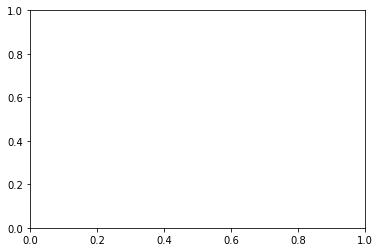

In [7]:
train(250)
Z_test_samples = test()
Clustering(Z_test_samples)